In [2]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.autograd as auto
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import librosa
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F


In [3]:
data=joblib.load('mfcc.sav')
len(data)

X,y=[],[]
for i in data:
    X.append(librosa.util.pad_center(i[0], 173, axis=1))
    y.append(i[1])

y_dictionary={'air_conditioner':0,
              'car_horn':1,
              'children_playing':2,
              'dog_bark':3,
              'drilling':4,
              'engine_idling':5,
              'gun_shot':6,
              'jackhammer':7,
              'siren':8,
              'street_music':9}

for i in range(0,len(y)):
    y[i]=y_dictionary.get(y[i])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train[2].shape

(40, 173)

In [6]:
BATCH_SIZE = 32

In [7]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

In [8]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE * 2)

In [9]:
# parameters 
N_STEPS = 40
N_INPUTS = 173
N_NEURONS = 173
N_OUTPUTS = 10
N_EPHOCS = 100

In [10]:
class Sound_RNN_LSTM(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(Sound_RNN_LSTM, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        print(batch_size, n_steps, n_inputs, n_neurons, n_outputs)
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,3,dropout=0.2)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons),torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.lstm(X)  
        out = self.FC(lstm_out[-1])
        
        return out.view(-1, self.n_outputs)


In [136]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Sound_RNN_LSTM(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=5e-3)
# optimizer = optim.SGD(model.parameters(), lr =5e-3, momentum=0.9)

def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

32 40 173 173 10


In [137]:
def eval_model(model, val_iter):
    total_epoch_loss = 0
    valid_acc = 0
    total_epoch_acc=0
    model.cuda()
    model.eval()
    num_corrects=0
    total=0
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            inputs = batch[0]
            
            target = batch[1]
            target = torch.autograd.Variable(target).long()
            
            inputs=inputs.cuda()
            target=target.cuda()
            prediction = model(inputs)
            loss = criterion(prediction, target)
        
            _, predicted = torch.max(prediction.data, 1)
            num_corrects += (predicted == target).sum().item()
            
            total+=target.size(0)
            total_epoch_loss += loss.item()
        acc = 100.0 * num_corrects/total
        
    return total_epoch_loss/len(val_iter), acc

In [138]:
for_plot_loss=[]
for_plot_acc=[]

val_loss=[]
val_acc=[]
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.cuda()
    model.train()
    num_corrects=0
    total=0
    
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        
        model.hidden = model.init_hidden() 
        
        inputs, labels = data
        inputs = inputs.view(-1, 40,173)
        
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        num_corrects += (predicted == labels.long()).sum().item()
        total+=labels.size(0)
    
    acc = 100.0 * num_corrects/total
    for_plot_loss.append(train_running_loss/i)
    for_plot_acc.append(acc)
    
    model.eval()
    
    valid_loss,valid_accuracy=eval_model(model,test_dl)
    
    val_loss.append(valid_loss)
    val_acc.append(valid_accuracy)
    
#     print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss / i, acc),'==>',valid_loss,valid_accuracy)
    print('Epoch:  %d | Train_Loss: %.4f | Train_Accuracy: %.2f | Validation_Loss: %.4f | Validation_Accuracy: %.2f' 
          %(epoch, train_running_loss / i, acc,valid_loss,valid_accuracy))

Epoch:  0 | Loss: 2.0053 | Train Accuracy: 22.22 ==> 1.724118379985585 30.358785648574056
Epoch:  1 | Loss: 1.7452 | Train Accuracy: 31.92 ==> 1.8807656624737907 29.254829806807727
Epoch:  2 | Loss: 1.6394 | Train Accuracy: 37.01 ==> 1.5541637574925142 40.47838086476541
Epoch:  3 | Loss: 1.5236 | Train Accuracy: 42.46 ==> 1.5467533644507914 42.870285188592455
Epoch:  4 | Loss: 1.3888 | Train Accuracy: 47.82 ==> 1.3684962567161112 49.12603495860166
Epoch:  5 | Loss: 1.2542 | Train Accuracy: 54.14 ==> 1.3428402858621933 51.14995400183992
Epoch:  6 | Loss: 1.1223 | Train Accuracy: 59.59 ==> 1.2646219239515417 56.48574057037718
Epoch:  7 | Loss: 1.0494 | Train Accuracy: 61.82 ==> 1.1912419445374434 60.25758969641215
Epoch:  8 | Loss: 0.9696 | Train Accuracy: 65.52 ==> 1.1378809494130753 59.98160073597056
Epoch:  9 | Loss: 0.8732 | Train Accuracy: 69.37 ==> 1.2138459542218376 59.61361545538178
Epoch:  10 | Loss: 0.7819 | Train Accuracy: 72.52 ==> 1.0754222414072823 64.48942042318308
Epoch: 

Epoch:  91 | Loss: 0.2685 | Train Accuracy: 90.39 ==> 0.8966229014536914 76.6329346826127
Epoch:  92 | Loss: 0.2640 | Train Accuracy: 90.92 ==> 0.9939163853140438 75.71297148114076
Epoch:  93 | Loss: 0.2547 | Train Accuracy: 90.96 ==> 0.9100099416340098 75.1609935602576
Epoch:  94 | Loss: 0.2342 | Train Accuracy: 91.67 ==> 0.8806184144581065 78.47286108555657
Epoch:  95 | Loss: 0.2731 | Train Accuracy: 90.57 ==> 0.8836751404930564 76.72493100275989
Epoch:  96 | Loss: 0.2651 | Train Accuracy: 91.17 ==> 0.8374626566382015 78.2888684452622
Epoch:  97 | Loss: 0.2502 | Train Accuracy: 91.44 ==> 0.8533960861318252 77.27690892364305
Epoch:  98 | Loss: 0.2306 | Train Accuracy: 92.11 ==> 0.959065672229318 75.71297148114076
Epoch:  99 | Loss: 0.2099 | Train Accuracy: 92.76 ==> 0.8560757391593036 78.38086476540938


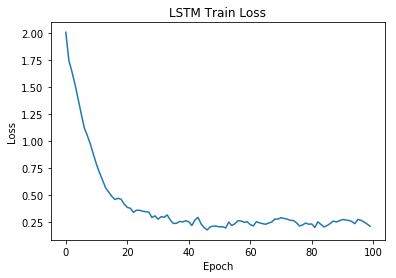

In [202]:
plt.plot(for_plot_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("LSTM Train Loss")
plt.show()

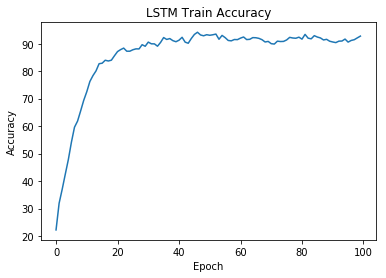

In [203]:
plt.plot(for_plot_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("LSTM Train Accuracy")
plt.show()

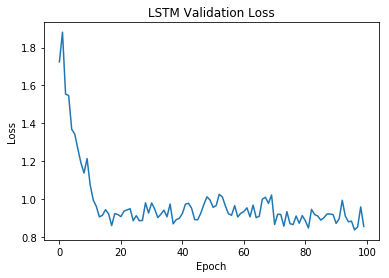

In [204]:
plt.plot(val_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("LSTM Validation Loss")
plt.show()

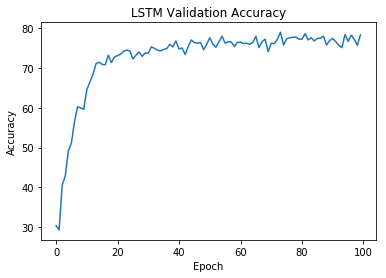

In [205]:
plt.plot(val_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("LSTM Validation Accuracy")
plt.show()

In [206]:
model

Sound_RNN_LSTM(
  (lstm): LSTM(173, 173, num_layers=3, dropout=0.2)
  (FC): Linear(in_features=173, out_features=10, bias=True)
)

In [207]:
torch.save(model.state_dict(), "C:/Users/Akhil/Desktop/DL/A2/lstm_for_val_weights.sav")

### Testing

In [11]:
net = Sound_RNN_LSTM(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
net.load_state_dict(torch.load("lstm_for_val_weights.sav"))

32 40 173 173 10


In [15]:
def test_prediction(model, x_te, y_te):
    model.cuda()
    model.eval()
    
    prediction_class=[]
    
    with torch.no_grad():
        for i in range(0,len(x_te)):
            inputs = x_te[i].reshape(1,40,173)
            
            target = y_te[i]
            target = torch.autograd.Variable(target).long()
            
            inputs=inputs.cuda()
            target=target.cuda()
            prediction = model(inputs)
            
            _, predicted = torch.max(prediction.data, 1)
            
#             print('predicted:',int(predicted),'--> Truth:',int(y_te[i]))
            prediction_class.append(int(predicted))
        return prediction_class

In [16]:
import pandas as pd

predicted_list=test_prediction(net, X_test, y_test)

In [17]:
excel=[]
for i in range(0,len(X_test)):
    temp=[]
    temp.append(i) #ID
    temp.append(predicted_list[i]) #predicted class
    excel.append(temp)

In [18]:
df = pd.DataFrame(excel)
filepath = 'test_predicted.xlsx'
df.to_excel(filepath,index=False)